# STEP 1. 작업환경 구성하기

In [1]:
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
!mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

# STEP 2. 데이터셋 구성하기

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# CIFAR-10 데이터셋 불러오기
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
print(train_x.shape)  

(50000, 32, 32, 3)


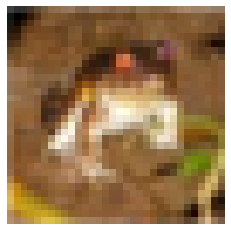

In [3]:
# 학습에 사용할 train_x의 이미지를 -1, 1로 정규화
train_x = (train_x - 127.5) / 127.5

# 로드한 학습 데이터 시각화로 확인
plt.imshow((train_x[0] * 127.5 + 127.5).astype(np.uint8))
plt.axis('off')
plt.savefig('first_image.png')  # Jupyter에서 시각화 확인용 저장

In [4]:
# tf.data.Dataset으로 미니배치 데이터셋 구성
BATCH_SIZE = 256
BUFFER_SIZE = 50000
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# STEP 3. 생성자 모델 구현하기

In [5]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

generator = make_generator_model()

In [6]:
# 랜덤 노이즈로 이미지 생성
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

(1, 32, 32, 3)


# STEP 4. 판별자 모델 구현하기

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator_model()

In [8]:
# 생성된 랜덤 이미지 판별 결과 확인
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00200354]], shape=(1, 1), dtype=float32)


# STEP 5. 손실함수와 최적화 함수 구현하기

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, 0.5), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, 0.5), tf.float32))
    return (real_accuracy + fake_accuracy) / 2.0

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# STEP 6. 훈련과정 상세 기능 구현하기

In [10]:
import os

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, discriminator_accuracy(real_output, fake_output)

def generate_and_save_images(model, epoch, test_input, save_dir):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = (predictions[i] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')
    plt.savefig(os.path.join(save_dir, f'image_at_epoch_{epoch:04d}.png'))
    plt.close(fig)

def draw_train_history(history, epoch, save_dir):
    plt.figure()
    plt.plot(history['gen_loss'], label='Generator Loss')
    plt.plot(history['disc_loss'], label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f'loss_at_epoch_{epoch:04d}.png'))
    plt.close()
    plt.figure()
    plt.plot(history['disc_accuracy'], label='Discriminator Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f'accuracy_at_epoch_{epoch:04d}.png'))
    plt.close()

checkpoint_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# STEP 7. 학습 과정 진행하기

In [11]:
EPOCHS = 50
save_every = 5
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
history = {'gen_loss': [], 'disc_loss': [], 'disc_accuracy': []}
generated_samples_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/generated_samples')
training_history_dir = os.path.expanduser('~/aiffel/dcgan_newimage/cifar10/training_history')

def train(dataset, epochs, save_every):
    for epoch in range(epochs):
        gen_loss_list = []
        disc_loss_list = []
        disc_accuracy_list = []
        for image_batch in dataset:
            g_loss, d_loss, d_acc = train_step(image_batch)
            gen_loss_list.append(g_loss)
            disc_loss_list.append(d_loss)
            disc_accuracy_list.append(d_acc)
        history['gen_loss'].append(np.mean(gen_loss_list))
        history['disc_loss'].append(np.mean(disc_loss_list))
        history['disc_accuracy'].append(np.mean(disc_accuracy_list))
        generate_and_save_images(generator, epoch + 1, seed, generated_samples_dir)
        draw_train_history(history, epoch + 1, training_history_dir)
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print(f'Epoch {epoch+1}, Gen Loss: {history["gen_loss"][-1]}, Disc Loss: {history["disc_loss"][-1]}, Disc Accuracy: {history["disc_accuracy"][-1]}')

train(train_dataset, EPOCHS, save_every)

Epoch 1, Gen Loss: 0.9690486192703247, Disc Loss: 1.106738805770874, Disc Accuracy: 0.711359977722168
Epoch 2, Gen Loss: 1.7266546487808228, Disc Loss: 0.776763916015625, Disc Accuracy: 0.8132792711257935
Epoch 3, Gen Loss: 1.7833011150360107, Disc Loss: 0.6056503653526306, Disc Accuracy: 0.8819116950035095
Epoch 4, Gen Loss: 1.9430433511734009, Disc Loss: 0.6563794612884521, Disc Accuracy: 0.8644770383834839
Epoch 5, Gen Loss: 1.9298081398010254, Disc Loss: 0.7163292765617371, Disc Accuracy: 0.851375162601471
Epoch 6, Gen Loss: 1.6751601696014404, Disc Loss: 0.7579068541526794, Disc Accuracy: 0.8408940434455872
Epoch 7, Gen Loss: 1.5835198163986206, Disc Loss: 0.852989137172699, Disc Accuracy: 0.8152742385864258
Epoch 8, Gen Loss: 1.4792627096176147, Disc Loss: 0.838854193687439, Disc Accuracy: 0.8097895383834839
Epoch 9, Gen Loss: 1.5966918468475342, Disc Loss: 0.8042907118797302, Disc Accuracy: 0.8185586929321289
Epoch 10, Gen Loss: 1.5653830766677856, Disc Loss: 0.8663508892059326,

In [12]:
# 학습 과정 시각화 (GIF 생성)
import imageio

def make_gif(images_dir, gif_name):
    images = []
    for epoch in range(1, EPOCHS + 1):
        filename = os.path.join(images_dir, f'image_at_epoch_{epoch:04d}.png')
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_name, images, fps=5)

make_gif(generated_samples_dir, 'cifar10_dcgan.gif')

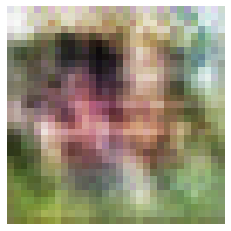

In [13]:
# 학습된 모델 로드 및 이미지 생성
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)
generator = checkpoint.generator
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5 + 127.5).astype(np.uint8)
plt.imshow(np_generated[0])
plt.axis('off')
plt.savefig('generated_image.png')

## 학습이 불안정한 결과

### 생성자 손실 (Gen Loss)
Epoch 1: 0.969 → Epoch 50: 1.442
중간에 Epoch 4에서 1.943까지 증가한 후 점차 감소하다가 다시 약간 증가하는 추세
전체적으로 손실이 안정화되지 않고 변동이 큼

### 판별자 손실 (Disc Loss)
Epoch 1: 1.106 → Epoch 50: 1.073
Epoch 3에서 0.605까지 내려갔다가 다시 증가하며 1.0 근처에서 변동이 있음
판별자도 손실이 일정하게 수렴하지 않고 오르내림

### 판별자 정확도 (Disc Accuracy)
Epoch 1: 0.711 → Epoch 50: 0.735
Epoch 3에서 0.882로 최고점을 찍은 후 점차 감소하며 0.7~0.8 사이를 맴돌고 있음

## Step8. (optional) GAN 훈련 과정 개선하기

### 1. 학습률 조정
현재 생성자와 판별자의 학습률이 서로 균형을 맞추지 못했을 가능성이 있음
ex) 생성자의 학습률을 조금 낮추거나(예: 0.0001), 판별자의 학습률을 살짝 높여서(예: 0.0004) 둘의 균형을 조정 가능

### 2. 모델 구조 변경
생성자나 판별자의 네트워크를 조금 더 깊게 만들거나(레이어 추가), 필터 수를 늘려서 모델의 표현력을 키워볼 수 있음
ex) 생성자에 컨볼루션 레이어를 하나 더 추가하거나 판별자의 필터를 64개에서 128개로 늘리는 식으로 실험 가능

### 3. 정규화 기법 사용
배치 정규화(Batch Normalization)나 드롭아웃(Dropout)을 추가해서 모델이 과적합되거나 불안정해지는 걸 줄일 수 있음
ex) 판별자에 드롭아웃(예: 0.3)을 넣으면 과도하게 강해지는 걸 막을 수 있음

### 4. 학습 데이터 증강
ex) 이미지 회전, 뒤집기, 자르기 같은 증강 기법을 써서 모델의 일반화 성능을 높일 수 있음

### 5. 더 많은 에포크 학습
현재: 50 에포크까지 학습
ex) 100 에포크 정도 더 학습하면서 손실이 안정화되는지 관찰

# Step8은 다음 파일에서 진행